In [1]:
from glob import glob

import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

In [2]:
data_set = pd.DataFrame()
for fpath in glob('data/*/reuters-*.json'):
    df = pd.read_json(fpath).T
    data_set = data_set.append(df)
    
data_set = data_set.fillna('')
print('Done!')

Done!


# Exploratory Data Analysis
our first task is to take a close look at the dataaet by loading and performing ex-ploratory data analysis. To do so, we must extract metadata and the text body from each document in the corpus. If we take a close look at the corpus, we find some interesting facts. Run the next three cells to visualize the results.

documents with at least one topic =  11367
max number of topics in one document =  16
number of topics =  120
number of places =  147
number of organizations =  32


<AxesSubplot:title={'center':'Dcoument Count by Organization'}>

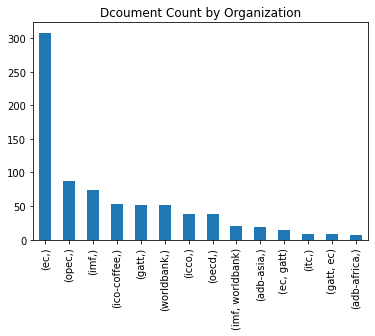

In [3]:
# getting elements using double loops
topics = set([x for sublist in data_set[u'topics'].values.tolist() for x in sublist])
places = set([x for sublist in data_set[u'places'].values.tolist() for x in sublist])
orgs = set([x for sublist in data_set[u'organisations'].values.tolist() for x in sublist])

data_set['topic_count'] = data_set[u'topics'].apply(lambda x: len([y for y in x]))
print("documents with at least one topic = ", len(data_set[data_set[u'topic_count']>0]))
print("max number of topics in one document = ", data_set[u'topic_count'].max())
print("number of topics = ", len(topics))
print("number of places = ", len(places))
print("number of organizations = ", len(orgs))

# 1:15 to get rid of none
data_set[u'organisations'].apply(tuple).value_counts()[1:15].plot(kind='bar',
                                                                  title='Dcoument Count by Organization')

<AxesSubplot:title={'center':'Document Count by Places outside US'}>

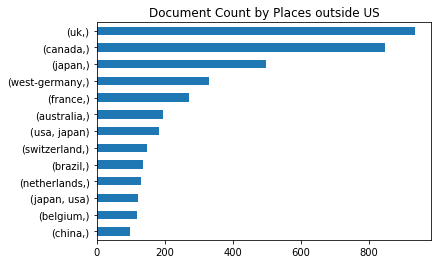

In [4]:
# 2:15 to get rid of us and none 
data_set[u'places'].apply(tuple).value_counts()[2:15].sort_values().plot(kind='barh',
                                                                        title='Document Count by Places outside US')

<AxesSubplot:title={'center':'Document Cont by Topic'}>

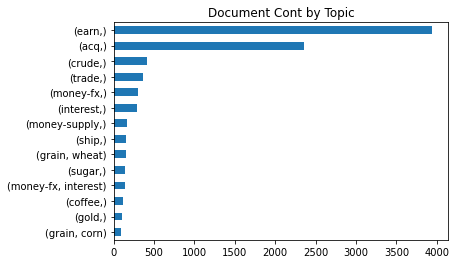

In [5]:
# # 1:15 to get rid of none
data_set[u'topics'].apply(tuple).value_counts()[1:15].sort_values().plot(kind='barh',
                                                                        title='Document Cont by Topic')

So far so good. But before we perform any NLP analysis, we will want to perform some text normalization:

- transform to lower case
- remove punctuation & numbers
- stem verbs
- remove stopwords

To do so, we define a Simple Tokenizer method that will be useful when creating document representations. For our analysis, we will analyze documents involving five topics (cocoa, trade, money-fx, coffe, and gold).

In [6]:
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
#from sklearn.preprocessing.label import MultiLabelBinarizer
from sklearn.preprocessing._label import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download("punkt")
nltk.download("stopwords", "data")
nltk.data.path.append('data')

label_binarizer = MultiLabelBinarizer()
data_target = label_binarizer.fit_transform(data_set[u'topics'])

stop_words = stopwords.words('english')
charfilter = re.compile('[a-zA-Z]+')

def simple_tokenizer(text):
    # transform to lower case
    words = map(lambda word: word.lower(), word_tokenize(text))
    # remove stopwords
    words = [word for word in words if word not in stop_words]
    # stem verbs
    tokens = (list(map(lambda token: PorterStemmer().stem(token), words)))
    # # remove punctuation & numbers
    ntokens = list(filter(lambda token: charfilter.match(token), tokens))
    return ntokens

vec = TfidfVectorizer(tokenizer=simple_tokenizer,
                      max_features=1000,
                      norm='l2')

mytopics = [u'cocoa', u'trade', u'money-supply', u'coffee', u'gold']
data_set = data_set[data_set[u'topics'].map(set(mytopics).intersection).apply(lambda x: len(x)>0)]
docs = list(data_set[u'body'].values)

dtm = vec.fit_transform(docs)

print("Number of documents with my topics = ", len(data_set))

[nltk_data] Downloading package punkt to /home/masao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to data...
[nltk_data]   Package stopwords is already up-to-date!


Number of documents with my topics =  1076


# Text Clustering
We want to see if clusters exist in the documents, so let's create some document representations through TFIDF. This gives us a document-term matrix, but typically the dimensions of this matrix is too large and the representaions are sparse. Let's first apply Principal Component Analysis(PCA) to reduce the dimensionality. The original TFIDF vectors have dimension = 1000. Let's take a look at the effect of dimensionallity reduction by plotting the proportion of explained variance of the data as a function of the number or principal components. 

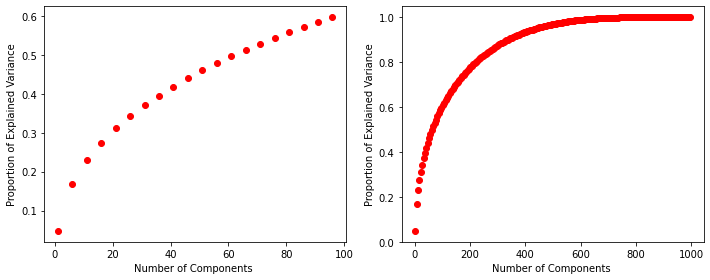

In [8]:
from sklearn.decomposition import PCA

fig = plt.figure(figsize=(10, 4))

def plot_pca(fig, max_components, plot_coord, step=5):
    explained_var = []
    
    for components in range(1, max_components, step):
        pca = PCA(n_components=components)
        pca.fit(dtm.toarray())
        explained_var.append(pca.explained_variance_ratio_.sum())
        
    ax = fig.add_subplot(plot_coord, 
                         xlabel="Number of Components ", 
                         ylabel="Proportion of Explained Variance")
    ax.scatter(range(1, max_components, step), explained_var, c="red")
    
plot_pca(fig, 100, 121)
plot_pca(fig, min(1000, len(data_set)), 122)
fig.tight_layout()
plt.show()

The graph above shows that half of the variance can be explained by 60 components. Let's apply this to the dataset, and visualize the results by plotting the first two PCA components of each document:

Explained variance of the PCA ste: 49%


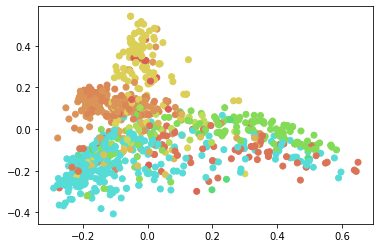

In [9]:
import seaborn as sns

components = 60

palette = np.array(sns.color_palette("hls", 120))
pca = PCA(n_components=components)
pca.fit(dtm.toarray())
# pca_dtm.shape: (number of topics, components)
pca_dtm = pca.transform(dtm.toarray())
data_target = label_binarizer.fit_transform(data_set[u"topics"])
plt.scatter(pca_dtm[:, 0], pca_dtm[:, 1], c=palette[data_target.argmax(axis=1).astype(int)])

explained_variance = pca.explained_variance_ratio_.sum()
print("Explained variance of the PCA ste: {}%".format(int(explained_variance * 100)))

We know that there are 5 distinct topics(though some documents might have overlap), so let's run the k-means algorithm with k=5 to examine document grouping:

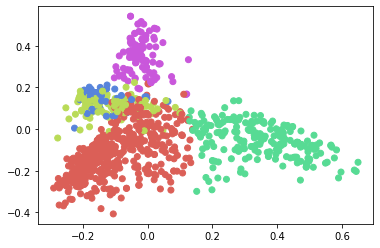

In [10]:
from sklearn.cluster import KMeans

palette = np.array(sns.color_palette("hls", 5))
model = KMeans(n_clusters=5, max_iter=100)
clustered = model.fit(pca_dtm)
centroids = model.cluster_centers_
y = model.predict(pca_dtm)

ax = plt.subplot()
sc = ax.scatter(pca_dtm[:, 0], pca_dtm[:, 1], c=palette[y.astype(np.int)])

Even with only capturing 50% of the variance, the clustering is fairly good when we compare with the manual (gold) labels.

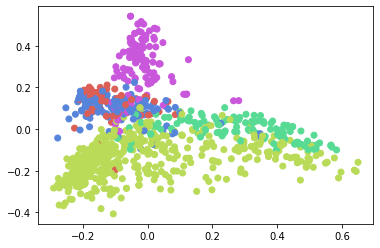

In [11]:
palette = np.array(sns.color_palette("hls", 5))

gold_labels = data_set["topics"].map(set(mytopics).intersection)\
                    .apply(lambda x: x.pop()).apply(lambda x: mytopics.index(x))

ax = plt.subplot()
sc = ax.scatter(pca_dtm[:, 0], pca_dtm[:, 1], c=palette[gold_labels])

Feel free to change the number of PCA components and see how well k-means performs vs. the gold labels.

# Topic Modeling
In addition to the lexical clustering of documents, let's see if we can discern any natural topic structure within the corpus. We apply the LSA and LDA algorithms, which will associate words to a set of topics, and topics to our set of documents.

## LSA
We start with the LSA algorithm, and set the number of dimensions to 60:

Explained variance of the SVD step: 49%


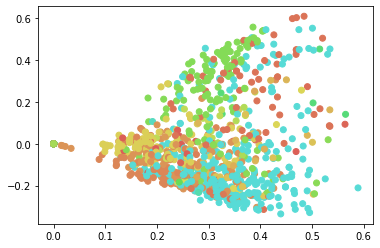

In [12]:
from sklearn.decomposition import TruncatedSVD

components = 60

palette = np.array(sns.color_palette("hls", 120))

lsa = TruncatedSVD(n_components=components)
lsa.fit(dtm)
lsa_dtm = lsa.transform(dtm)

plt.scatter(lsa_dtm[:, 0], lsa_dtm[:, 1], c=palette[data_target.argmax(axis=1).astype(int)])

explained_variance = lsa.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

As with PCA, let's apply k-means with k=5 clusters:

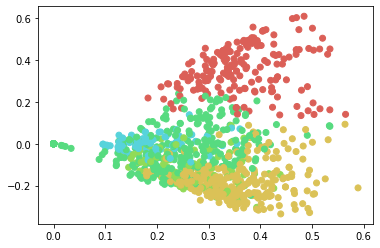

In [13]:
palette = np.array(sns.color_palette("hls", 8))

model = KMeans(n_clusters=5, max_iter=100)
clustered = model.fit(lsa_dtm)
centroids = model.cluster_centers_
y = model.predict(lsa_dtm)

ax = plt.subplot()
sc = ax.scatter(lsa_dtm[:, 0], lsa_dtm[:, 1], c=palette[y.astype(np.int)])

Let's examine the documents of one of these clusters:

In [14]:
topic = u"coffee"

data_set[gold_labels == mytopics.index(topic)][u"body"].head(10)

42     International Coffee Organization, ICO,\nprodu...
75     International Coffee Organization (ICO)\nexpor...
232    Talks on the possibility of reintroducing\nglo...
235    Indonesia"s agriculture sector will grow\nby j...
249    The International Coffee Organization\n(ICO ) ...
290    Talks on coffee export quotas at the\nInternat...
402    Coffee quota talks at the International\nCoffe...
562    Talks at the extended special meeting of\nthe ...
754    Efforts to break an impasse between\ncoffee ex...
842    A special meeting of the International\nCoffee...
Name: body, dtype: object

## LDA
Let's see if the LDA algorithm can do better as a Baysian approach to document clustering and topic modeling. We set the number of topics to the known number of topics = 5.

In [20]:
from sklearn.decomposition  import LatentDirichletAllocation

components = 5
n_top_words = 10

palette = np.array(sns.color_palette("hls", 120))

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        massage = "Topic #%d: " % topic_idx
        massage += " ".join(feature_names[i] 
                            for i in topic.argsort()[:-n_top_words - 1:-1])
        print(massage)
    print()
    
lda = LatentDirichletAllocation(n_components=components, 
                                max_iter=5, 
                                learning_method="online")
lda.fit(dtm)
lda_dtm = lda.transform(dtm)

vec_feature_names = vec.get_feature_names()
print("my topics: ", mytopics, "\n")
print_top_words(lda, vec_feature_names, n_top_words)

my topics:  ['cocoa', 'trade', 'money-supply', 'coffee', 'gold'] 

Topic #0: cocoa buffer icco stock deleg coast consum rule ivori ivorian
Topic #1: said pct need trade dlr year agricultur french china growth
Topic #2: borrow fed wednesday two-week said bank dlr week discount half
Topic #3: said trade u.s. japan export coffe would ec market offici
Topic #4: billion dlr pct mln gold mine said februari januari bank



The LDA results are encouraging, and we can easily discern 4 of the 5 original topics from the list of words associated with each topic.

# Document Classification
Now let's see if we can build classifiers to possibly identify the topics above. We first randomize and split our dataset into train and test sets.

In [21]:
from sklearn.model_selection import train_test_split

data_set['label'] = gold_labels

X_train, X_test, y_train, y_test = train_test_split(data_set, 
                                                    gold_labels, 
                                                    test_size=0.2, 
                                                    random_state=10)
print("Train set = ", len(X_train))
print("Test set = ", len(X_test))

X_train = X_train[u"body"]
X_test = X_test[u"body"]

Train set =  860
Test set =  216


Then craete a pipeline that builds classifiers based on 5 models: Naive Bayes, Logistic Regression, SVM, K-Nearest Neighbor and Random Forest.

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

models = [("multinomial_nb", MultinomialNB()),
          ('log_reg', LogisticRegression()),
          ('linear_svc', LinearSVC()),
          ('knn', KNeighborsClassifier(n_neighbors=6)),
          ('rf', RandomForestClassifier(n_estimators=6))]

We then train each model on the training set and evaluate on the test set. For each model, we want to see the precision, recall, F1 score and support(number of samples) for each topic class.

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

for m_name, model in models:
    pipeline = Pipeline([('vec', TfidfVectorizer(tokenizer=simple_tokenizer)), 
                         (m_name, model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print("model = ", model, "\n")
    print(classification_report(y_test, y_pred, digits=6))

model =  MultinomialNB() 

              precision    recall  f1-score   support

           0   1.000000  0.285714  0.444444        14
           1   0.670807  1.000000  0.802974       108
           2   1.000000  0.375000  0.545455        48
           3   1.000000  0.666667  0.800000        21
           4   1.000000  0.760000  0.863636        25

    accuracy                       0.754630       216
   macro avg   0.934161  0.617476  0.691302       216
weighted avg   0.835404  0.754630  0.729241       216

model =  LogisticRegression() 

              precision    recall  f1-score   support

           0   1.000000  0.571429  0.727273        14
           1   0.776978  1.000000  0.874494       108
           2   1.000000  0.500000  0.666667        48
           3   0.950000  0.904762  0.926829        21
           4   1.000000  1.000000  1.000000        25

    accuracy                       0.851852       216
   macro avg   0.945396  0.795238  0.839053       216
weighted avg   0.8

The results seem to indicate that a linear SVM model seems to perform the best, with Random Forest a close second. This is a bit misleading, since we didn't tune any of these models to obtain our results. Hyperparameter tuning can significantly affect how well a classifier performs. Let's try tuning the LinearSVC model. The learnable parameters are:

In [25]:
vectorizer = TfidfVectorizer(tokenizer=simple_tokenizer)
model = LinearSVC()
print("vec params = ", vectorizer.get_params().keys(), "\n")
print("model params = ", model.get_params().keys())

vec params =  dict_keys(['analyzer', 'binary', 'decode_error', 'dtype', 'encoding', 'input', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'norm', 'preprocessor', 'smooth_idf', 'stop_words', 'strip_accents', 'sublinear_tf', 'token_pattern', 'tokenizer', 'use_idf', 'vocabulary']) 

model params =  dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'multi_class', 'penalty', 'random_state', 'tol', 'verbose'])


We want to tune these parameters by using grid search with cross-validation. Note that cross-validation is important as we do not want tune with our test set, which we will use only at the end to assess performance. Note also that this can take a while!

In [27]:
import warnings
from sklearn.model_selection import GridSearchCV

warnings.simplefilter('ignore')

pipeline = Pipeline([("vec", vectorizer),
                     ("model", model)])

parameters = {"vec__ngram_range": ((1, 1), (1, 2)),
              "vec__max_features": (500, 1000),
              "model__loss": ("hinge", "squared_hinge"),
              "model__C": (1, 0.9)}

grid_search = GridSearchCV(pipeline, parameters, verbose=1)
grid_search.fit(X_train, y_train)

y_pred = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred, digits=6))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
              precision    recall  f1-score   support

           0   0.900000  0.642857  0.750000        14
           1   0.961905  0.935185  0.948357       108
           2   0.854545  0.979167  0.912621        48
           3   0.904762  0.904762  0.904762        21
           4   1.000000  1.000000  1.000000        25

    accuracy                       0.930556       216
   macro avg   0.924242  0.892394  0.903148       216
weighted avg   0.932888  0.930556  0.929298       216



As you see, the SVM model typically outperforms other machine learning algorithms, and often provides as the state-of-the-art in quality. Unfortunately, **SVM suffers from several major drawbacks, including the inability to scale to large datasets.** As we will learn in later chapters, neural networks can bypass the limitations of SVMs.